In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

# Funciones de Yellow Brick
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier.threshold import DiscriminationThreshold
from yellowbrick.model_selection import ValidationCurve

sns.set_palette("colorblind")
SEED = 42

In [2]:
# Importing data
engine_ds= pd.read_csv("../data/interim/engine_data_w_efficiency_downsampled.csv")
engine_df= pd.read_csv("../data/interim/engine_data_w_efficiency.csv")

In [3]:
rpm_idx, oil_pressure_idx, coolant_pressure_idx, oil_temp_idx, coolant_temp_idx = 0, 1, 3, 4, 5

class AttributesAdder(BaseEstimator, TransformerMixin):
    
    # Constructor of the Class
    def __init__(self, add_oil_system=True, add_coolant_system=True):
        self.add_oil_system = add_oil_system
        self.add_coolant_system = add_coolant_system
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.add_oil_system:
            oil_efficiency = 1 / (X[:, rpm_idx] * X[:, oil_temp_idx])
            X = np.c_[X, oil_efficiency]
            
        if self.add_coolant_system:
            cool_efficiency = (1 / X[:, rpm_idx]) * X[:, coolant_temp_idx]
            X = np.c_[X, cool_efficiency]
            
        return X 

In [11]:
def prep_engine_data(df: pd.DataFrame, target_label: str):
    prep_pipe = Pipeline([
        ("attr_adder", AttributesAdder()),
        ("std_scaler", StandardScaler())
    ])

    X = df.drop(target_label, axis=1)
    y = df[target_label]

    data_prepared = prep_pipe.fit_transform(X.values)
    X_train, X_test, y_train, y_test = train_test_split(
        data_prepared, y, 
        test_size=0.2, 
        random_state=SEED,
        stratify=y
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train,
        test_size=X_test.shape[0],
        random_state=SEED,
        stratify=y_train
    )
    return X_train, X_test, X_val, y_train, y_test, y_val

In [12]:
def get_validation_curves(X_train, y_train, model, params: dict, scoring: str = "roc_auc"):
    fig, axes = plt.subplots(1, len(params), figsize=(14, 7))

    pos=0
    for name, param_range in params.items():
        print(param_range)
        viz = ValidationCurve(
            model,
            param_name= name,
            param_range=param_range,
            cv=10,
            scoring="roc_auc",
            ax=axes[pos]
        )
        pos=pos+1
        viz.fit(X_train, y_train)
        # viz.show()
        
    # Display the plot
    plt.tight_layout()
    plt.show()

In [13]:
def find_best_model(X_train, y_train, model: ClassifierMixin, params):
    rand_search = RandomizedSearchCV(
        model,
        scoring = 'roc_auc',
        param_distributions = params,
        random_state = SEED,
        cv=10,
        return_train_score=True,
    )

    rand_search.fit(X_train, y_train)
    
    df_best_params = pd.DataFrame(rand_search.cv_results_)
    cm = sns.diverging_palette(5, 250, as_cmap=True)
    comparative = (
        pd.concat([
            df_best_params['params'].apply(pd.Series),
            df_best_params[['mean_train_score', 'mean_test_score', 'rank_test_score']]],
            axis = 1
        )
        .sort_values(by = 'rank_test_score')
        .style.background_gradient(cmap=cm, subset = ['mean_train_score', 'mean_test_score'])
    )
    display(comparative)
    
    return rand_search.best_estimator_, comparative

In [35]:
def get_scores(experiment_name, X_train, X_test, X_val, y_train, y_test, y_val, best_model):
    clf_model = best_model.fit( X_train, y_train )
    
    # Especificamos la gráfica
    visualizer = DiscriminationThreshold(
        best_model,							# Pasar el estimador del mejor modelo que
                                            # se obtiene de la validación cruzada.
        exclude = ["queue_rate"]			# Excluimos de la gráfica algunas métricas
    )
    # Ajustamos la visualización a los datos de entrenamiento
    visualizer.fit(X_val, y_val)
    # Dibujamos la visualización.
    visualizer.show()
    
    predictions = clf_model.predict(X_test)
    insight = {
        'model': [experiment_name],
        'auc': [roc_auc_score(y_test, predictions)],
        'score': [f1_score(y_test, predictions)] ,
        'precision': [precision_score(y_test, predictions)],
        'recall': [recall_score(y_test, predictions)],
    }
    
    display(pd.DataFrame(insight))

    cm = ConfusionMatrix(
        best_model,
        classes=['Bad_condition','Good_condition']
    )
    cm.fit(X_train, y_train)
    cm.score(X_val, y_val)
    cm.show()
    
    

In [36]:
def get_model_insigths(experiment_name: str, df: pd.DataFrame, model: ClassifierMixin, params: dict):
    X_train, X_test, X_val, y_train, y_test, y_val = prep_engine_data(df, target_label="Engine Condition")
    
    get_validation_curves(X_train, y_train, model, params)
    
    best_model, comparative = find_best_model(X_train, y_train, model, params)
    get_scores(experiment_name, X_train, X_test, X_val, y_train, y_test, y_val, best_model)
    
    return comparative, best_model

## XGB

['gbtree', 'dart']


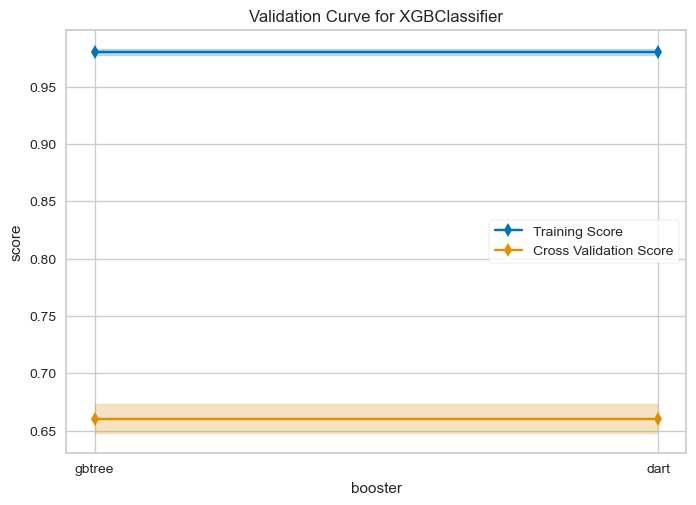

[0.1, 0.2, 0.3]


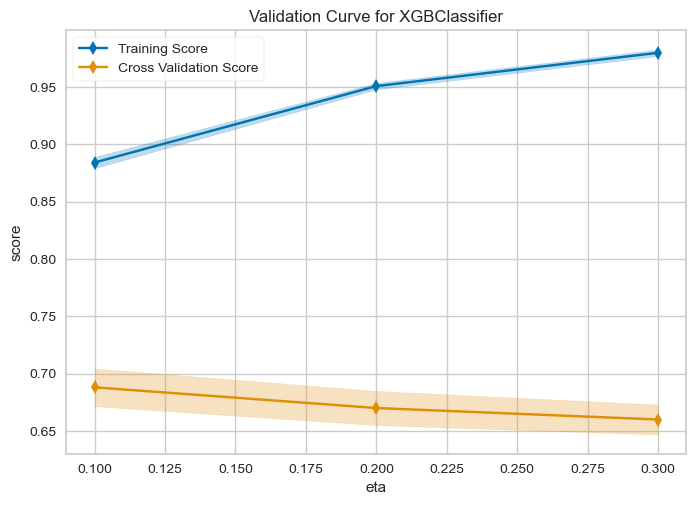

[3, 5, 7, 10]


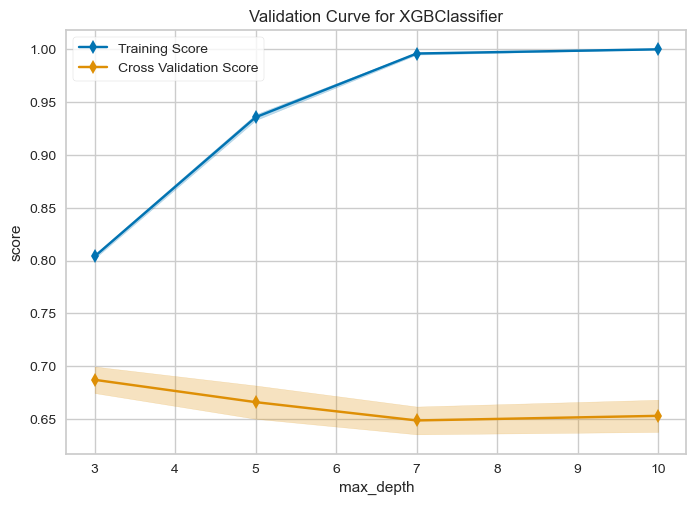

[1, 5, 7, 10]


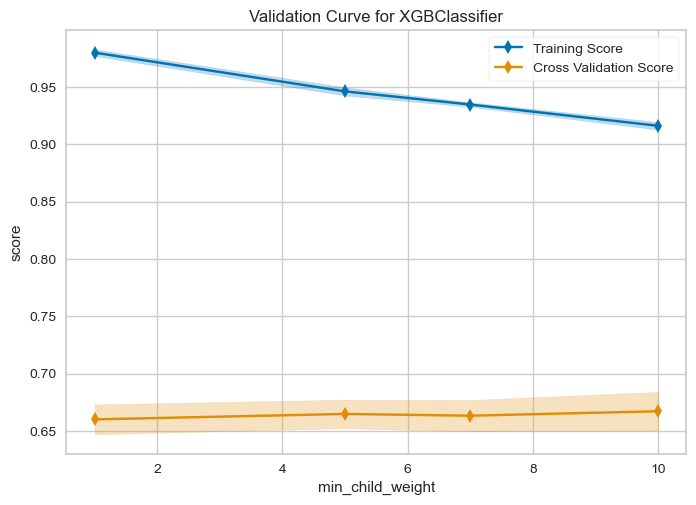

[0, 1, 2, 3, 4, 5]


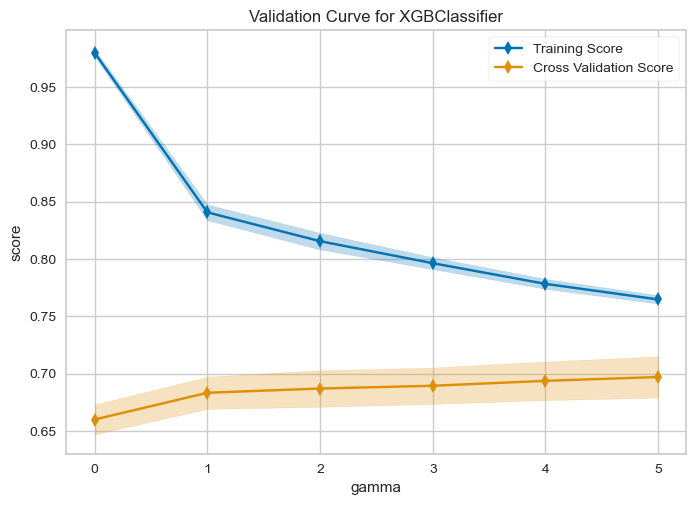

[1, 0.7, 0.5]


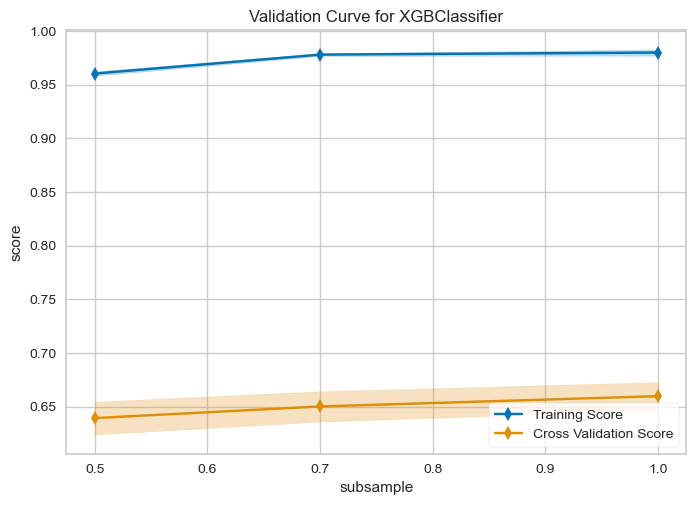

[1, 0.7, 0.5]


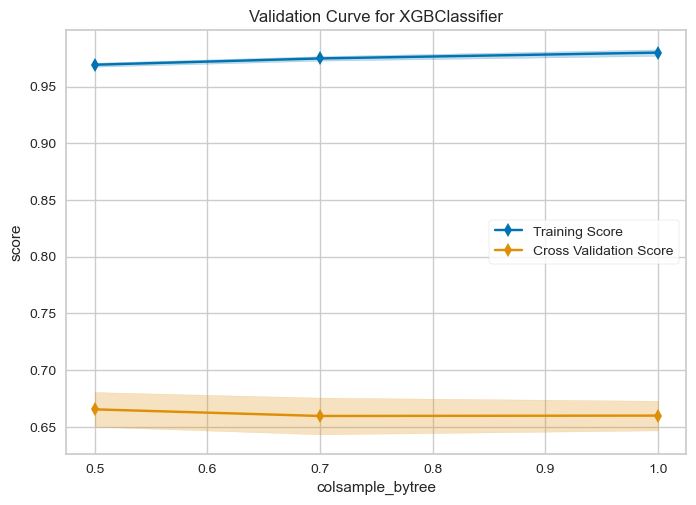

[1, 0.7, 0.5]


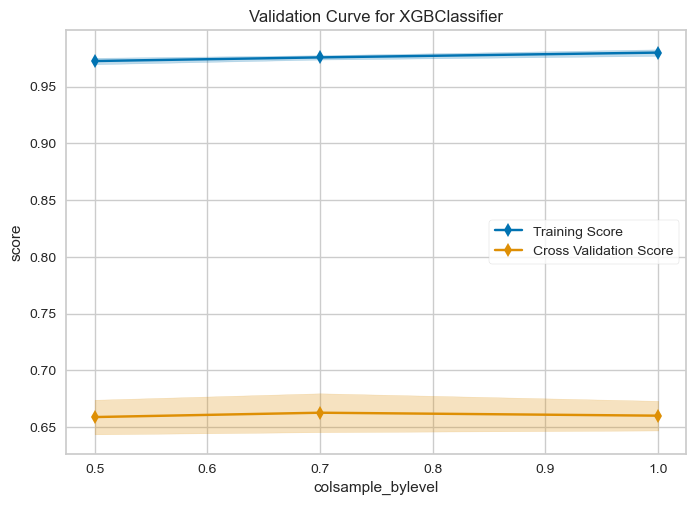

[1, 0.7, 0.5]


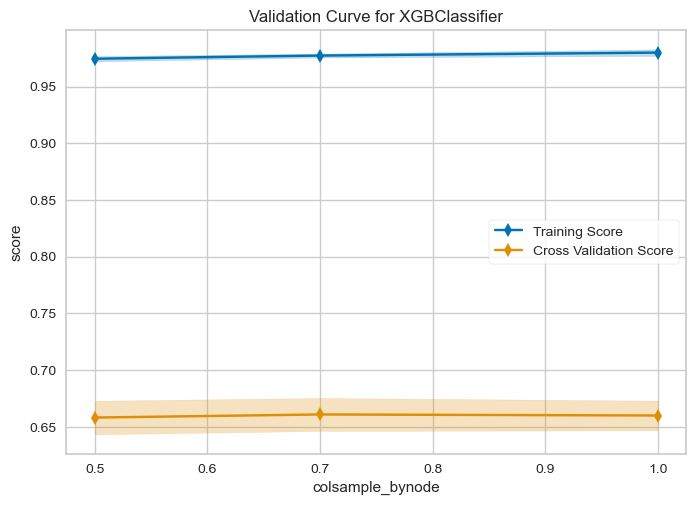

[1, 5, 7, 10]


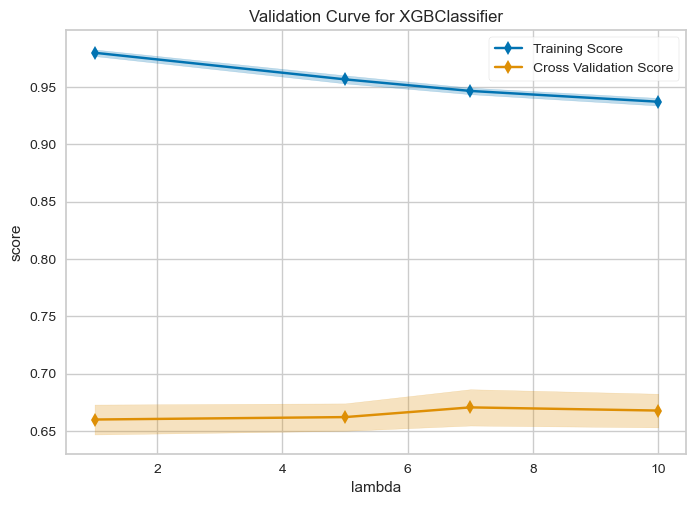

[1, 5, 7, 10]


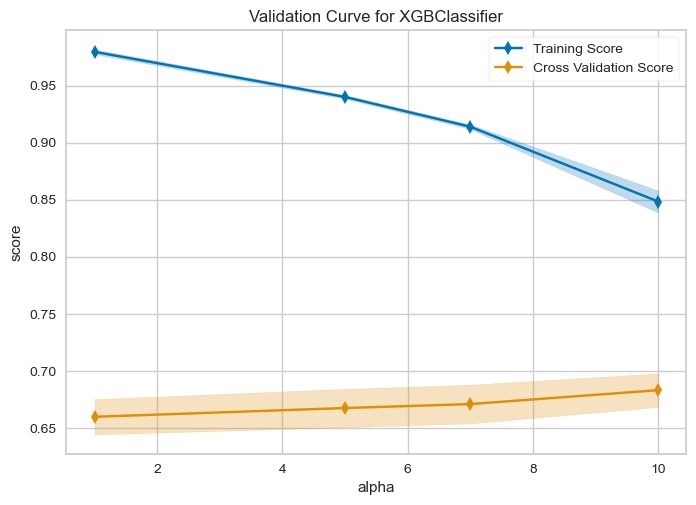

['auto', 'exact', 'approx', 'hist']


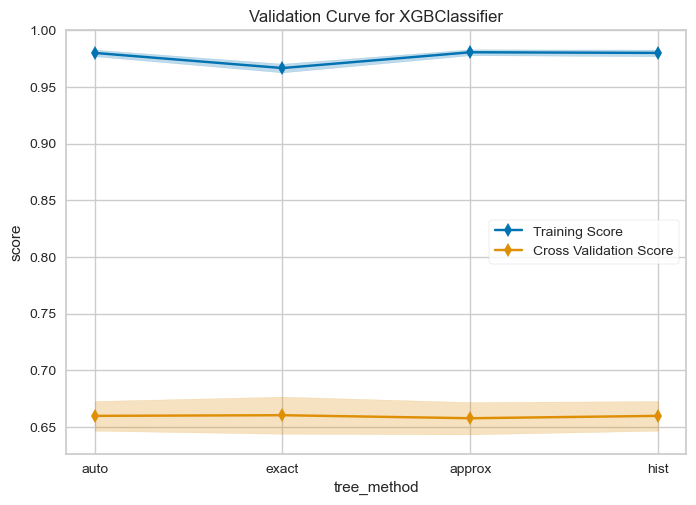

[0, 0.25, 0.5, 0.75, 1]


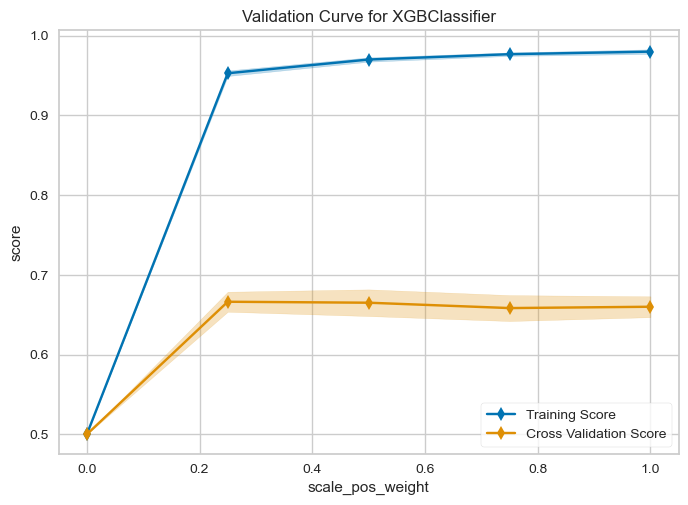

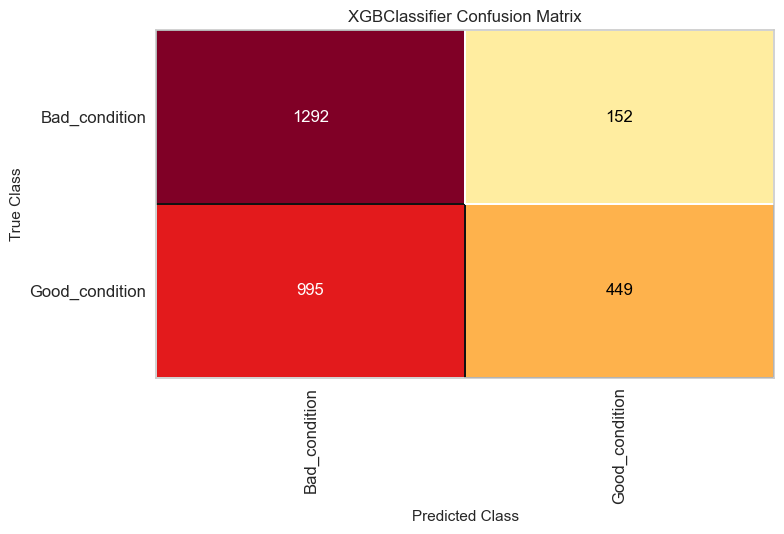

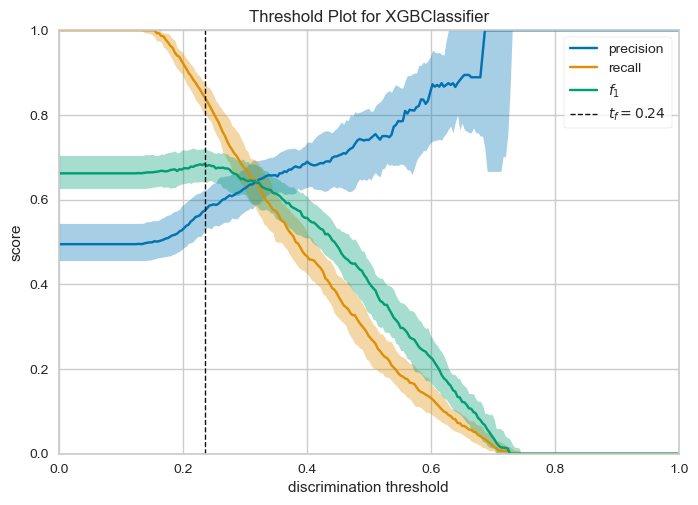

In [44]:
clf_xgb = xgb.XGBClassifier(random_state=SEED)

params = {
    "booster": ['gbtree', 'dart'],
    "eta": [0.1, 0.2, 0.3],
    "max_depth": [3, 5, 7, 10],
    "min_child_weight": [1, 5, 7, 10],
    "gamma": [0, 1, 2, 3, 4, 5],
    "subsample": [1, 0.7, 0.5],
    "colsample_bytree": [1, 0.7, 0.5],
    "colsample_bylevel": [1, 0.7, 0.5],
    "colsample_bynode": [1, 0.7, 0.5],
    "lambda": [1, 5, 7, 10],
    "alpha": [1, 5, 7, 10],
    "tree_method": ["auto", "exact", "approx", "hist"],
    "scale_pos_weight": [0, 0.25, 0.50, 0.75, 1],
}

result, model = get_model_insigths(engine_ds, clf_xgb, params)

In [45]:
result

,tree_method,subsample,scale_pos_weight,min_child_weight,max_depth,lambda,gamma,eta,colsample_bytree,colsample_bynode,colsample_bylevel,booster,alpha,mean_train_score,mean_test_score,rank_test_score
6,exact,0.700000,0.500000,5,7,10,5,0.100000,0.500000,0.700000,1.000000,dart,1,0.731368,0.707618,1
4,auto,0.700000,1.000000,7,10,10,4,0.100000,0.500000,0.500000,1.000000,gbtree,5,0.724930,0.706379,2
3,hist,0.700000,0.500000,7,5,5,3,0.300000,0.700000,1.000000,0.700000,dart,7,0.722040,0.705974,3
2,approx,1.000000,0.250000,5,7,10,1,0.300000,0.700000,0.700000,0.700000,dart,5,0.725541,0.705362,4
9,approx,0.700000,0.750000,1,7,5,2,0.300000,0.500000,1.000000,1.000000,dart,7,0.736244,0.704629,5
1,auto,0.700000,0.500000,1,3,10,4,0.300000,0.500000,1.000000,0.700000,dart,5,0.719359,0.704242,6
5,auto,1.000000,0.250000,7,10,5,5,0.200000,1.000000,0.700000,1.000000,dart,10,0.712538,0.700902,7
0,approx,0.500000,0.250000,1,10,7,2,0.100000,0.700000,0.500000,0.500000,dart,10,0.708116,0.700085,8
7,approx,0.700000,1.000000,1,7,5,1,0.100000,1.000000,1.000000,0.700000,dart,7,0.779021,0.698311,9
8,approx,0.700000,0.000000,10,10,5,0,0.100000,0.700000,0.700000,0.500000,dart,10,0.500000,0.500000,10


## XGBC 2

['gbtree', 'dart']
[0.1, 0.2, 0.3]
[3, 5, 7, 10]
[1, 5, 7, 10]
[0, 1, 2, 3, 4, 5]
[1, 0.7, 0.5]
[1, 0.7, 0.5]
[1, 0.7, 0.5]
[1, 0.7, 0.5]
[1, 5, 7, 10]
[1, 5, 7, 10]
['auto', 'exact', 'approx', 'hist']
[0, 0.25, 0.5, 0.75, 1]


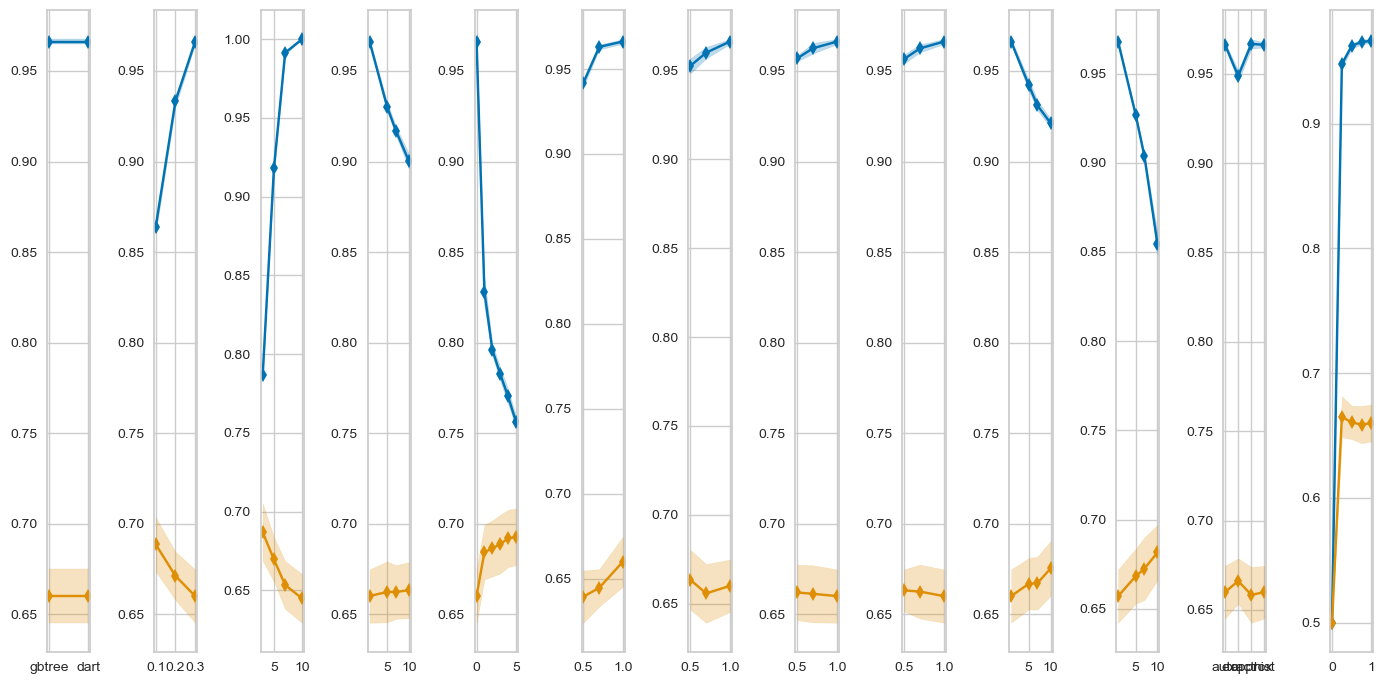

,tree_method,subsample,scale_pos_weight,min_child_weight,max_depth,lambda,gamma,eta,colsample_bytree,colsample_bynode,colsample_bylevel,booster,alpha,mean_train_score,mean_test_score,rank_test_score
6,exact,0.700000,0.500000,5,7,10,5,0.100000,0.500000,0.700000,1.000000,dart,1,0.730713,0.702152,1
3,hist,0.700000,0.500000,7,5,5,3,0.300000,0.700000,1.000000,0.700000,dart,7,0.717176,0.701189,2
4,auto,0.700000,1.000000,7,10,10,4,0.100000,0.500000,0.500000,1.000000,gbtree,5,0.718207,0.700429,3
9,approx,0.700000,0.750000,1,7,5,2,0.300000,0.500000,1.000000,1.000000,dart,7,0.735006,0.700174,4
2,approx,1.000000,0.250000,5,7,10,1,0.300000,0.700000,0.700000,0.700000,dart,5,0.721309,0.700136,5
1,auto,0.700000,0.500000,1,3,10,4,0.300000,0.500000,1.000000,0.700000,dart,5,0.713488,0.699010,6
7,approx,0.700000,1.000000,1,7,5,1,0.100000,1.000000,1.000000,0.700000,dart,7,0.779164,0.697891,7
0,approx,0.500000,0.250000,1,10,7,2,0.100000,0.700000,0.500000,0.500000,dart,10,0.702988,0.694593,8
5,auto,1.000000,0.250000,7,10,5,5,0.200000,1.000000,0.700000,1.000000,dart,10,0.707544,0.694537,9
8,approx,0.700000,0.000000,10,10,5,0,0.100000,0.700000,0.700000,0.500000,dart,10,0.500000,0.500000,10


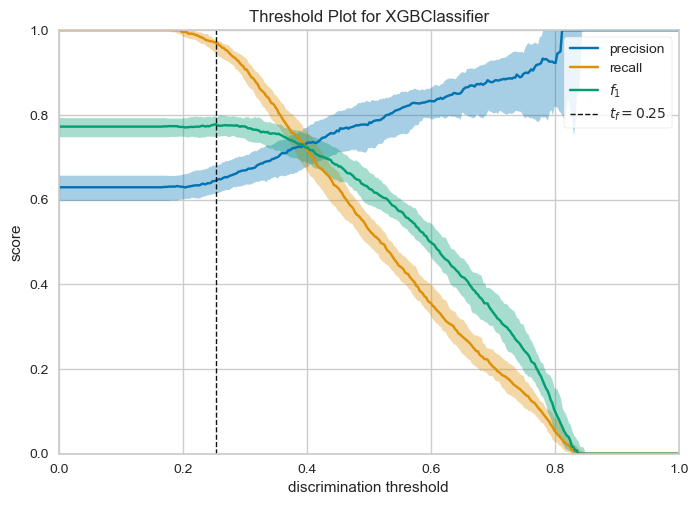

,model,auc,score,precision,recall
0,xgbc 2,0.648961,0.65145,0.786001,0.556232


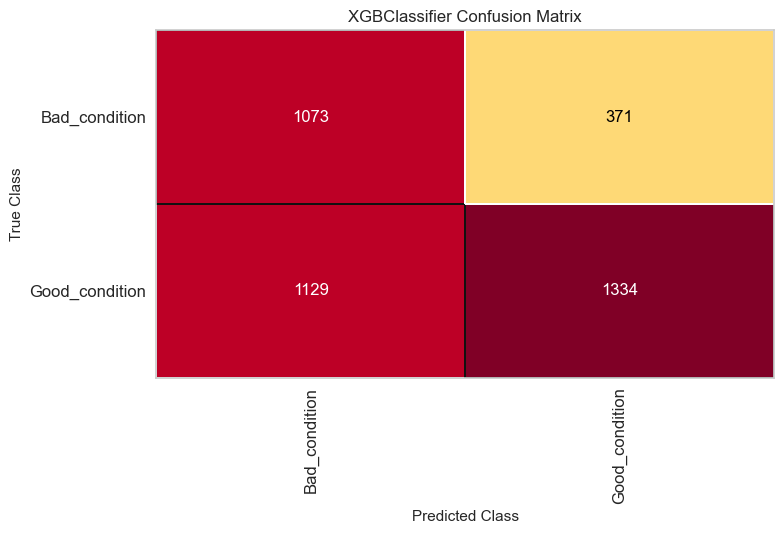

In [37]:
clf_xgb = xgb.XGBClassifier(random_state=SEED)

params = {
    "booster": ['gbtree', 'dart'],
    "eta": [0.1, 0.2, 0.3],
    "max_depth": [3, 5, 7, 10],
    "min_child_weight": [1, 5, 7, 10],
    "gamma": [0, 1, 2, 3, 4, 5],
    "subsample": [1, 0.7, 0.5],
    "colsample_bytree": [1, 0.7, 0.5],
    "colsample_bylevel": [1, 0.7, 0.5],
    "colsample_bynode": [1, 0.7, 0.5],
    "lambda": [1, 5, 7, 10],
    "alpha": [1, 5, 7, 10],
    "tree_method": ["auto", "exact", "approx", "hist"],
    "scale_pos_weight": [0, 0.25, 0.50, 0.75, 1],
}

result, model_clf = get_model_insigths("xgbc 2", engine_df, clf_xgb, params)

## Random Forest

[100, 105, 110, 115]


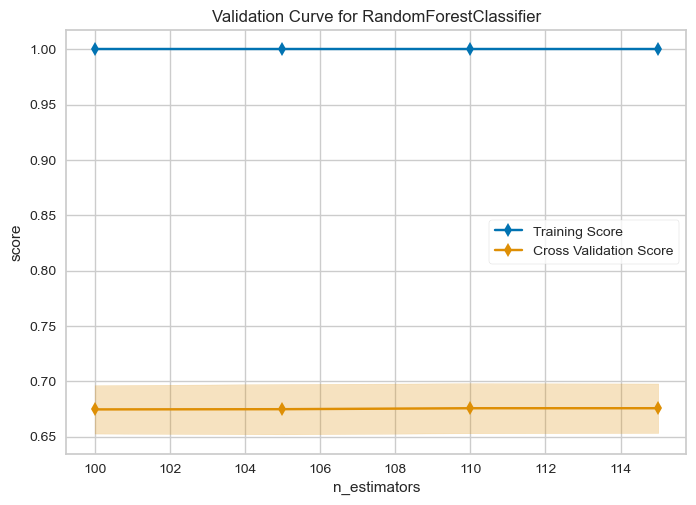

[5, 8, 15]


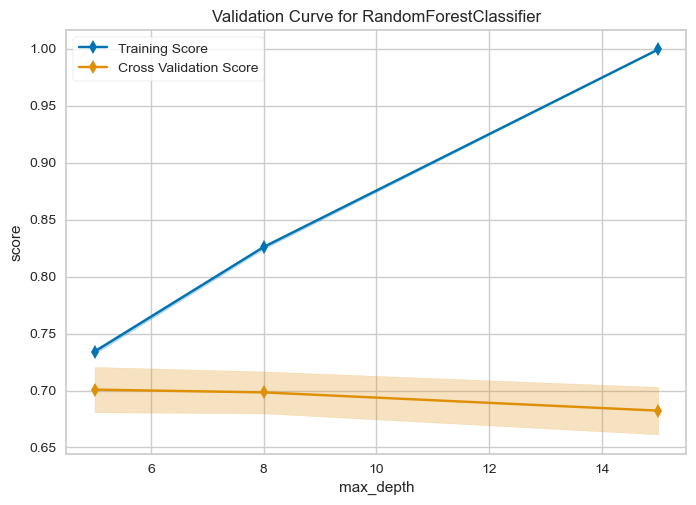

[2, 3, 4, 5, 6, 7, 8, 9]


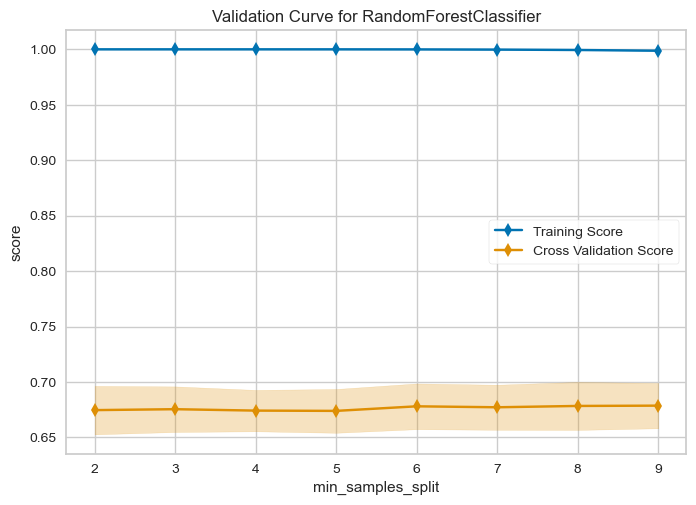

[2]


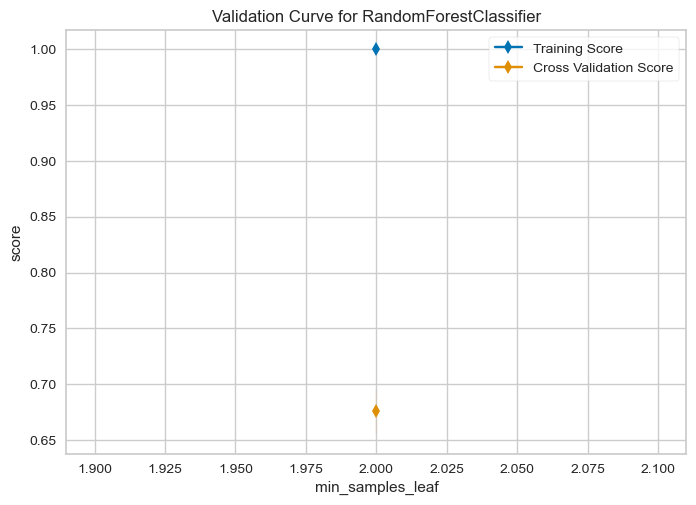

['log2', 'sqrt']


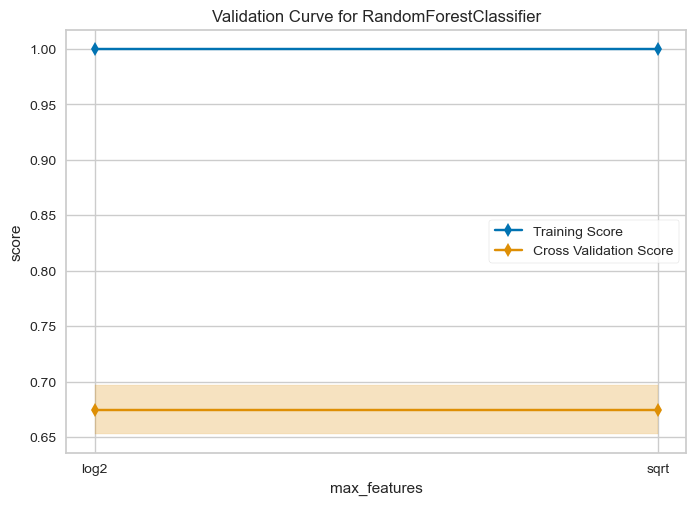

['balanced', 'balanced_subsample']


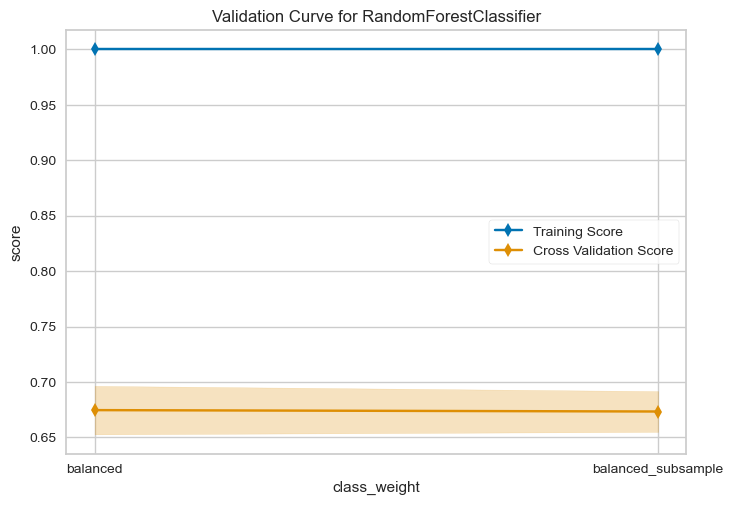

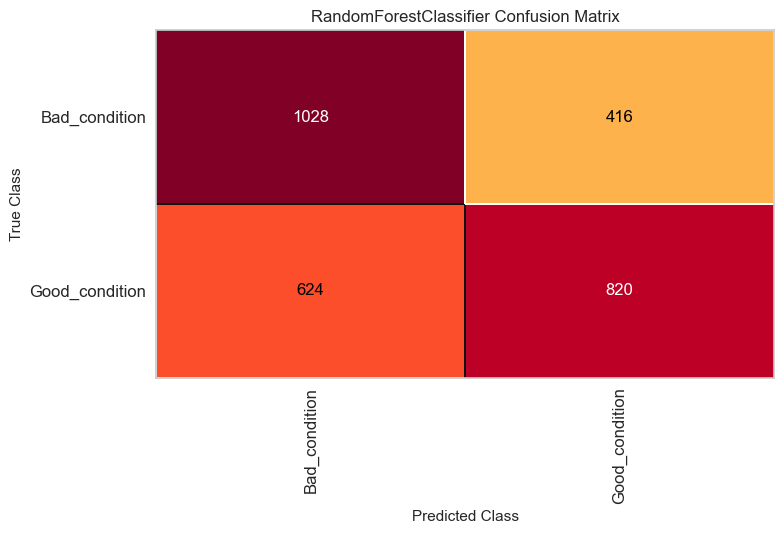

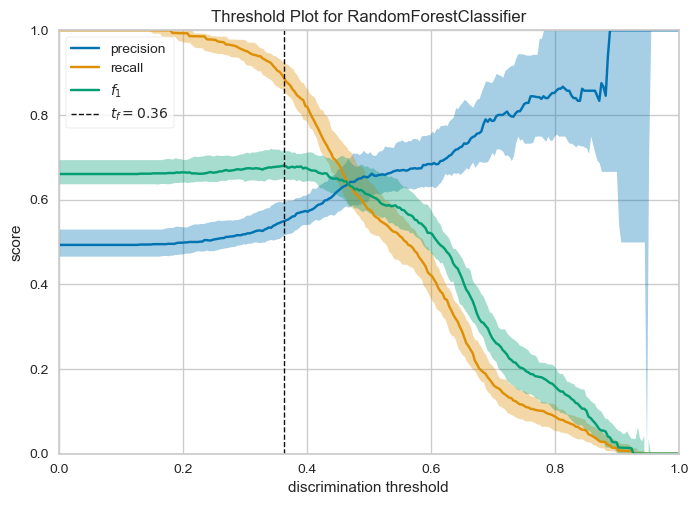

In [49]:
params = {
    'n_estimators': [*range(100,120,5)],
    'max_depth': [5, 8, 15],
    'min_samples_split':[*range(2,10,1)],
    'min_samples_leaf' : [2],
    'max_features' : ['log2', 'sqrt'],
    "class_weight": ['balanced', 'balanced_subsample']
}

clf_rfc = RandomForestClassifier(random_state=SEED, n_jobs=-1)

result, model_clf = get_model_insigths(engine_ds, clf_rfc, params)

In [50]:
result

,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,class_weight,mean_train_score,mean_test_score,rank_test_score
1,110,8,2,sqrt,5,balanced_subsample,0.733975,0.700749,1
6,105,2,2,sqrt,5,balanced,0.734105,0.700742,2
9,110,5,2,sqrt,5,balanced_subsample,0.734072,0.700739,3
4,100,8,2,sqrt,5,balanced,0.733884,0.700700,4
0,100,5,2,log2,8,balanced_subsample,0.821084,0.699099,5
7,110,6,2,sqrt,8,balanced,0.819962,0.698776,6
2,115,2,2,sqrt,15,balanced_subsample,0.996255,0.686081,7
8,115,7,2,sqrt,15,balanced_subsample,0.989481,0.686069,8
5,100,7,2,sqrt,15,balanced_subsample,0.989139,0.685726,9
3,100,5,2,log2,15,balanced_subsample,0.994386,0.684210,10


In [ ]:
pred = model.predict(X_test)
